In [1]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.preprocessing import normalize
import multiprocessing
from eunjeon import Mecab

In [2]:
raw_sentence_file_name = './dataset/nsmc/processed/processed_ratings.txt'
tokenized_sentence_file_name = './dataset/nsmc/processed/processed_ratings_tokenized.txt'
w2v_model_file_name = './dataset/nsmc/model/w2v/w2v'

MAX_VOCAB_SIZE = 10000
EMBEDDING_SIZE = 100
WORKERS = multiprocessing.cpu_count() - 1
WINDOW_SIZE = 5
EPOCHS = 10

In [3]:
UNK_TOKEN = '<UNK>'
PAD_TOKEN = '<PAD>'
tokenizer = Mecab()

In [4]:
def create_tokenized_sentence_file(raw_file_name, out_file_name, tokenizer):    
    print(f'Tokenizing을 시작합니다. {raw_file_name}')
    with open(raw_file_name, 'r', encoding='utf-8') as fi, \
        open(out_file_name, 'w', encoding='utf-8') as fo :
        for i, sentence in enumerate(fi):
            tokenized_words = tokenizer.morphs(sentence.replace('\n', '').strip())
            fo.writelines(' '.join(tokenized_words) + '\n')
            
            if i % 10000 == 0 and i > 0:
                print(f'{i} 번째 tokenizing이 완료되었습니다.')
    
    print(f'Tokenizing이 완료되었습니다. {out_file_name}')                
    

In [5]:
create_tokenized_sentence_file(
    raw_sentence_file_name, tokenized_sentence_file_name, Mecab())

Tokenizing을 시작합니다. ./dataset/nsmc/processed/processed_ratings.txt
10000 번째 tokenizing이 완료되었습니다.
20000 번째 tokenizing이 완료되었습니다.
30000 번째 tokenizing이 완료되었습니다.
40000 번째 tokenizing이 완료되었습니다.
50000 번째 tokenizing이 완료되었습니다.
60000 번째 tokenizing이 완료되었습니다.
70000 번째 tokenizing이 완료되었습니다.
80000 번째 tokenizing이 완료되었습니다.
90000 번째 tokenizing이 완료되었습니다.
100000 번째 tokenizing이 완료되었습니다.
110000 번째 tokenizing이 완료되었습니다.
120000 번째 tokenizing이 완료되었습니다.
130000 번째 tokenizing이 완료되었습니다.
140000 번째 tokenizing이 완료되었습니다.
150000 번째 tokenizing이 완료되었습니다.
160000 번째 tokenizing이 완료되었습니다.
170000 번째 tokenizing이 완료되었습니다.
180000 번째 tokenizing이 완료되었습니다.
190000 번째 tokenizing이 완료되었습니다.
Tokenizing이 완료되었습니다. ./dataset/nsmc/processed/processed_ratings_tokenized.txt


In [23]:
def make_w2v_model(in_file_name, out_file_name,
                   max_vocab_size=10000, embedding_size=100,
                   epochs=10, window=5, workers=3):
    # 빈도수 상위 vocab_size 내에 존재하는 단어 중 최소 빈도수를 구함
    def get_min_freq_count(sentences, max_freq_rank):
        from itertools import chain
        import nltk

        fdist = nltk.FreqDist(chain.from_iterable(sentences))
        return fdist.most_common(max_freq_rank)[-1][1] # the count of the the top-kth word

    # 단어 모음
    corpus = [sentence.strip().split(' ') 
              for sentence in open(in_file_name, 'r', encoding='utf-8').readlines()]
    # 빈도수 상위 n위의 최소빈도수 구함 (word2vec 훈련 시 그 이하는 버리기 위함)
    min_freq_cnt = get_min_freq_count(corpus, max_vocab_size)
    
    # gensim word2vec call
    w2v_model = Word2Vec(corpus, 
                     size=embedding_size, 
                     workers=workers, 
                     min_count=min_freq_cnt,
                     sg=1, 
                     iter=epochs,
                     window=window)
    # 저장
    w2v_model.save(out_file_name)        
    
    return _post_w2v_process(w2v_model)   
    

In [24]:
def _post_w2v_process(w2v_model):    
    # unknown, padding 토큰 추가
    def _append_unk_pad_vectors(embeddings):
        embedding_size = embeddings.shape[1]
        def get_truncated_normal(mean=0, sd=1, low=-1, upp=1):
            from scipy.stats import truncnorm
            return truncnorm(
                    (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

        return np.append(embeddings, 
                         get_truncated_normal().rvs(embedding_size * 2).reshape(2, embedding_size), axis=0)    
        
    index2word = w2v_model.wv.index2word
    # unk, pad 추가
    index2word.append( UNK_TOKEN )
    index2word.append( PAD_TOKEN )    
    
    w2v = w2v_model.wv.vectors
    # unk, pad에 해당하는 normal 초기화된 벡터 추가
    w2v = _append_unk_pad_vectors(w2v)
    # cosine유사도 체크를 위해 normalize
    unit_w2v = normalize(w2v, norm='l2', axis=1)

    # word를 index로 변환
    word2index = {w:i for i, w in enumerate(index2word)}
    # 사전. word를 vector로 변환
    dictionary = {w:v for w, v in zip(index2word, unit_w2v)}    
    
    return {
        'w2v_model'   : w2v_model, 
        'index2word'  : index2word, 
        'word2index'  : word2index,
        #'word2vec'    : dictionary,
        'weight'      : w2v,
        'norm_weight' : unit_w2v
    }

In [25]:
# word2vec 모델 만들고 저장. 그 외 필요한 값들 리턴
w2v_output = make_w2v_model(tokenized_sentence_file_name, 
                   w2v_model_file_name, 
                   max_vocab_size=MAX_VOCAB_SIZE, 
                   embedding_size=EMBEDDING_SIZE,
                   epochs=EPOCHS,
                   window=WINDOW_SIZE,
                   workers=WORKERS)

In [33]:
print( len(w2v_output['index2word']) )
print( len(w2v_output['word2index']) )
print( len(w2v_output['word2vec']) )

print( w2v_output['index2word'][200] )
print( w2v_output['word2index']['송강호'] )
print( w2v_output['word2vec']['송강호'] )
print( w2v_output['weight'][2583] )
print( w2v_output['norm_weight'][2583] )

10103
10103
10103
합니다
2583
[ 0.06799535  0.08396171  0.09730418 -0.01916396 -0.02565846 -0.04756482
  0.14125267  0.07309338  0.1176164  -0.0693256  -0.0606813   0.13984307
 -0.01671652 -0.10818528  0.15250708  0.1274831   0.15139319 -0.05651428
 -0.00436119  0.08637035 -0.0618348  -0.07455906 -0.09245661  0.1162488
 -0.05550465 -0.02128308 -0.24207388 -0.07053547  0.23203259  0.10352287
  0.18113775  0.1856614  -0.06077575  0.01799496 -0.07674533 -0.02762538
 -0.09257406 -0.04788052 -0.01863103  0.02443167  0.02701665  0.06260194
  0.04399027 -0.03605681 -0.06963098 -0.11580769  0.03737633  0.02979887
 -0.19544944 -0.05230658 -0.09552763 -0.12082402  0.11442728 -0.07512301
 -0.01516158  0.00509392 -0.09439256 -0.20054326  0.04235131 -0.13987744
 -0.06633811 -0.02393311 -0.03603131 -0.21474782  0.05268152  0.04619233
 -0.0902705   0.00646385  0.03379602 -0.03032579  0.03311474  0.0556166
  0.02584037  0.04816295 -0.05636433  0.0758813   0.02893989 -0.06260369
  0.11094676  0.12373943 -

In [31]:
# 훈련 완료된 모델 있으면 로드해서 쓴다.
def load_w2v_model(model_file_name):
    w2v_model = Word2Vec.load(model_file_name)

    return _post_w2v_process(w2v_model)

In [32]:
# 훈련 완료된 모델 있으면 로드해서 쓴다.
w2v_output = load_w2v_model(w2v_model_file_name)

In [227]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Dense, Embedding, Activation, LSTM, Bidirectional, GRU, Softmax, Dropout
from keras.preprocessing.sequence import pad_sequences

In [ ]:
'''
model = Sequential()
model.add(w2v_model.wv.get_keras_embedding(train_embeddings=False))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # 출력층
model.summary()
'''

In [15]:
train_fname = './dataset/nsmc/processed/processed_ratings_train.txt'
test_fname = './dataset/nsmc/processed/processed_ratings_test.txt'

In [34]:
def load_dataset(filename):
    X, y = [], []
    tokenizer = Mecab()
    with open(filename, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            # 문장과 label 읽음
            sentence, label = line.strip().split('\u241E')
            # 문장 tokenizing
            tokenized_sentence = tokenizer.morphs(sentence.replace('\n', '').strip())
            # word -> vecs
            sequence = [word2index[t] if t in word2index else word2index[ UNK_TOKEN ]
                                    for t in tokenized_sentence]
            X.append( sequence )
            y.append( int(label) )

    # 최대 길이로 padding
    X = pad_sequences( X, maxlen=20, padding='post', value=word2index[PAD_TOKEN] )
    #X = [unit_w2v[x] for x in X]
    return np.array(X), np.array(y)

        

In [35]:
train_X, train_y = load_dataset(train_fname)
test_X, test_y = load_dataset(test_fname)

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(149995, 20)
(149995,)
(49997, 20)
(49997,)


In [97]:
vocab_size, embedding_dim = w2v_output['weight'].shape

In [98]:
vocab_size, embedding_dim

(10103, 100)

In [230]:
class Attention(Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        # (batch, )
        self.w1 = Dense(units, activation='tanh')
        self.w2 = Dense(1)    
        self.softmax_ = Softmax(axis=1)
        
    def call(self, x):
        # (batch, seq, embedding_dim*2) -> # (batch, seq, dec_units)
        x = self.w1(x)
        # (batch, seq, dec_units) -> # (batch, seq, 1)
        score = self.softmax_( self.w2(x) )

        return tf.squeeze( tf.matmul(tf.transpose(x, perm=[0, 2, 1]), score ), axis=-1 )
        

In [231]:
class MoviePosNegClassifier(Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, 
                 batch_size, embedding_weights, apply_attention, train_embedding_layer, dropout):
        super(MoviePosNegClassifier, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_weights])
        self.lstm = Bidirectional( LSTM(self.dec_units, return_sequences=True) )
        self.fc1 = Dense(128, activation='relu')
        self.fc2 = Dense(1, activation='sigmoid')
        self.do1 = Dropout(dropout)
        self.do2 = Dropout(dropout)
        
        self.attention = Attention(self.dec_units)
        self.embedding.trainable = train_embedding_layer
        self.apply_attention = apply_attention
        
    def call(self, x):
        # (batch, seq) -> (batch, seq, embedding_dim)        
        x = self.embedding(x)
        x = self.do1(x)
        # (batch, seq, embedding_dim) -> (batch, seq, embedding_dim*2)        
        x = self.lstm(x)
        
        # (batch, seq, embedding_dim*2) -> (batch, embedding_dim)        
        if self.apply_attention:
            x = self.attention(x)
        
        # (batch, embedding_dim) -> (batch, 128)    
        x = self.fc1(x)
        x = self.do2(x)
        x = self.fc2(x)
        
        return x

In [232]:
def plot_hist(hist):
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()    

In [233]:
def train_and_evaluate(vocab_size, embedding_dim, dec_units, epochs, batch_size, 
       weights, apply_attention, is_embedding_layer_freezing, dropout):
    model = MoviePosNegClassifier(
        vocab_size, 
        embedding_dim, 
        dec_units, 
        batch_size,
        weights,
        apply_attention,
        is_embedding_layer_freezing,
        dropout
    )

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(
        train_X, train_y, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    test_score = model.evaluate(test_X, test_y, verbose=2)
    
    plot_hist(history)
    
    return f'{apply_attention}-{is_embedding_layer_freezing}-{dropout}', history, test_score
    

{'True-True-0.2-0': <tensorflow.python.keras.callbacks.History at 0x1c24b108610>,
 'True-True-0.2-1': <tensorflow.python.keras.callbacks.History at 0x1c246e37d90>,
 'True-True-0.3-0': <tensorflow.python.keras.callbacks.History at 0x1c242426be0>}

Epoch 1/10
938/938 [==============================] - 30s 27ms/step - loss: 0.4507 - accuracy: 0.7826 - val_loss: 0.3314 - val_accuracy: 0.8551
Epoch 2/10
938/938 [==============================] - 24s 26ms/step - loss: 0.3274 - accuracy: 0.8560 - val_loss: 0.3235 - val_accuracy: 0.8593
Epoch 3/10
938/938 [==============================] - 24s 26ms/step - loss: 0.2965 - accuracy: 0.8736 - val_loss: 0.3077 - val_accuracy: 0.8664
Epoch 4/10
938/938 [==============================] - 24s 26ms/step - loss: 0.2706 - accuracy: 0.8856 - val_loss: 0.3139 - val_accuracy: 0.8695
Epoch 5/10
938/938 [==============================] - 24s 26ms/step - loss: 0.2547 - accuracy: 0.8943 - val_loss: 0.3088 - val_accuracy: 0.8709
Epoch 6/10
938/938 [==============================] - 24s 26ms/step - loss: 0.2338 - accuracy: 0.9027 - val_loss: 0.3256 - val_accuracy: 0.8692
Epoch 7/10
938/938 [==============================] - 24s 26ms/step - loss: 0.2159 - accuracy: 0.9115 - val_loss: 0.3386 - val_accuracy:

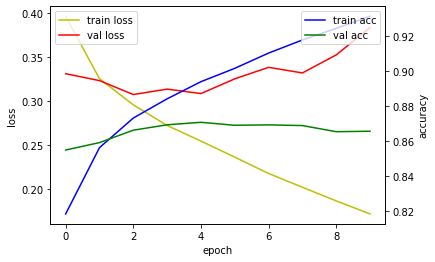

Epoch 1/10
938/938 [==============================] - 29s 27ms/step - loss: 0.4546 - accuracy: 0.7792 - val_loss: 0.3431 - val_accuracy: 0.8487
Epoch 2/10
938/938 [==============================] - 24s 25ms/step - loss: 0.3302 - accuracy: 0.8547 - val_loss: 0.3371 - val_accuracy: 0.8522
Epoch 3/10
938/938 [==============================] - 24s 25ms/step - loss: 0.2876 - accuracy: 0.8764 - val_loss: 0.3285 - val_accuracy: 0.8612
Epoch 4/10
938/938 [==============================] - 24s 25ms/step - loss: 0.2538 - accuracy: 0.8918 - val_loss: 0.3277 - val_accuracy: 0.8591
Epoch 5/10
938/938 [==============================] - 24s 25ms/step - loss: 0.2310 - accuracy: 0.9038 - val_loss: 0.3380 - val_accuracy: 0.8616
Epoch 6/10
938/938 [==============================] - 24s 26ms/step - loss: 0.2047 - accuracy: 0.9162 - val_loss: 0.3847 - val_accuracy: 0.8621
Epoch 7/10
938/938 [==============================] - 24s 25ms/step - loss: 0.1848 - accuracy: 0.9240 - val_loss: 0.3870 - val_accuracy:

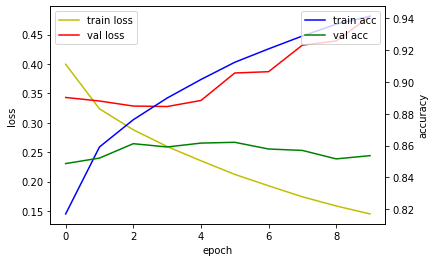

Epoch 1/10
938/938 [==============================] - 22s 16ms/step - loss: 0.4860 - accuracy: 0.7606 - val_loss: 0.3689 - val_accuracy: 0.8386
Epoch 2/10
938/938 [==============================] - 14s 15ms/step - loss: 0.3821 - accuracy: 0.8268 - val_loss: 0.3392 - val_accuracy: 0.8490
Epoch 3/10
938/938 [==============================] - 14s 15ms/step - loss: 0.3627 - accuracy: 0.8369 - val_loss: 0.3274 - val_accuracy: 0.8556
Epoch 4/10
938/938 [==============================] - 14s 15ms/step - loss: 0.3480 - accuracy: 0.8454 - val_loss: 0.3287 - val_accuracy: 0.8553
Epoch 5/10
938/938 [==============================] - 14s 15ms/step - loss: 0.3353 - accuracy: 0.8517 - val_loss: 0.3155 - val_accuracy: 0.8632
Epoch 6/10
938/938 [==============================] - 14s 15ms/step - loss: 0.3260 - accuracy: 0.8573 - val_loss: 0.3220 - val_accuracy: 0.8583
Epoch 7/10
938/938 [==============================] - 14s 15ms/step - loss: 0.3138 - accuracy: 0.8624 - val_loss: 0.3074 - val_accuracy:

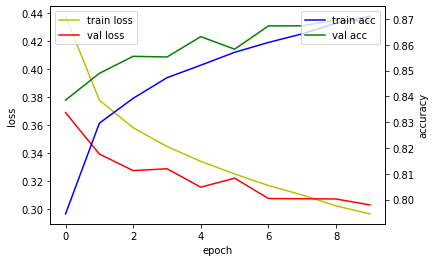

Epoch 1/10
938/938 [==============================] - 19s 16ms/step - loss: 0.5350 - accuracy: 0.7264 - val_loss: 0.4178 - val_accuracy: 0.8081
Epoch 2/10
938/938 [==============================] - 14s 15ms/step - loss: 0.4358 - accuracy: 0.7957 - val_loss: 0.3717 - val_accuracy: 0.8371
Epoch 3/10
938/938 [==============================] - 14s 15ms/step - loss: 0.3978 - accuracy: 0.8171 - val_loss: 0.3526 - val_accuracy: 0.8422
Epoch 4/10
938/938 [==============================] - 14s 15ms/step - loss: 0.3761 - accuracy: 0.8296 - val_loss: 0.3444 - val_accuracy: 0.8478
Epoch 5/10
938/938 [==============================] - 14s 15ms/step - loss: 0.3670 - accuracy: 0.8348 - val_loss: 0.3420 - val_accuracy: 0.8490
Epoch 6/10
938/938 [==============================] - 14s 15ms/step - loss: 0.3571 - accuracy: 0.8398 - val_loss: 0.3337 - val_accuracy: 0.8529
Epoch 7/10
938/938 [==============================] - 14s 15ms/step - loss: 0.3476 - accuracy: 0.8465 - val_loss: 0.3253 - val_accuracy:

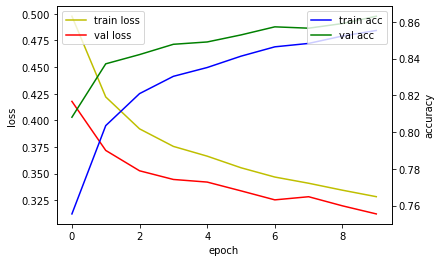

Epoch 1/10
938/938 [==============================] - 29s 26ms/step - loss: 0.4699 - accuracy: 0.7651 - val_loss: 0.3513 - val_accuracy: 0.8426
Epoch 2/10
938/938 [==============================] - 23s 25ms/step - loss: 0.3384 - accuracy: 0.8505 - val_loss: 0.3261 - val_accuracy: 0.8588
Epoch 3/10
938/938 [==============================] - 24s 25ms/step - loss: 0.3047 - accuracy: 0.8690 - val_loss: 0.3288 - val_accuracy: 0.8565
Epoch 4/10
938/938 [==============================] - 24s 26ms/step - loss: 0.2827 - accuracy: 0.8792 - val_loss: 0.3180 - val_accuracy: 0.8672
Epoch 5/10
938/938 [==============================] - 24s 25ms/step - loss: 0.2611 - accuracy: 0.8904 - val_loss: 0.3115 - val_accuracy: 0.8685
Epoch 6/10
938/938 [==============================] - 24s 25ms/step - loss: 0.2437 - accuracy: 0.8993 - val_loss: 0.3223 - val_accuracy: 0.8677
Epoch 7/10
938/938 [==============================] - 23s 25ms/step - loss: 0.2285 - accuracy: 0.9065 - val_loss: 0.3377 - val_accuracy:

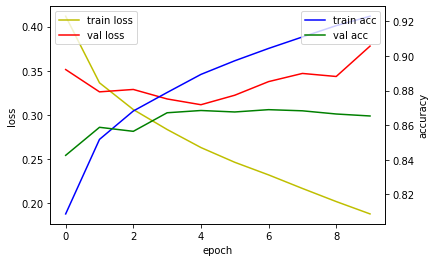

Epoch 1/10
938/938 [==============================] - 28s 26ms/step - loss: 0.4544 - accuracy: 0.7792 - val_loss: 0.3431 - val_accuracy: 0.8482
Epoch 2/10
938/938 [==============================] - 23s 24ms/step - loss: 0.3282 - accuracy: 0.8551 - val_loss: 0.3317 - val_accuracy: 0.8520
Epoch 3/10
938/938 [==============================] - 23s 25ms/step - loss: 0.2936 - accuracy: 0.8742 - val_loss: 0.3264 - val_accuracy: 0.8595
Epoch 4/10
938/938 [==============================] - 23s 25ms/step - loss: 0.2647 - accuracy: 0.8879 - val_loss: 0.3289 - val_accuracy: 0.8604
Epoch 5/10
938/938 [==============================] - 23s 25ms/step - loss: 0.2391 - accuracy: 0.9005 - val_loss: 0.3487 - val_accuracy: 0.8611
Epoch 6/10
938/938 [==============================] - 23s 25ms/step - loss: 0.2232 - accuracy: 0.9082 - val_loss: 0.3648 - val_accuracy: 0.8598
Epoch 7/10
938/938 [==============================] - 23s 25ms/step - loss: 0.2008 - accuracy: 0.9174 - val_loss: 0.3773 - val_accuracy:

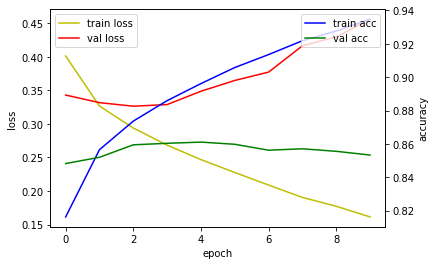

Epoch 1/10
938/938 [==============================] - 18s 15ms/step - loss: 0.5149 - accuracy: 0.7386 - val_loss: 0.3890 - val_accuracy: 0.8241
Epoch 2/10
938/938 [==============================] - 13s 14ms/step - loss: 0.4107 - accuracy: 0.8113 - val_loss: 0.3716 - val_accuracy: 0.8331
Epoch 3/10
938/938 [==============================] - 13s 14ms/step - loss: 0.3860 - accuracy: 0.8248 - val_loss: 0.3454 - val_accuracy: 0.8474
Epoch 4/10
938/938 [==============================] - 13s 14ms/step - loss: 0.3674 - accuracy: 0.8352 - val_loss: 0.3362 - val_accuracy: 0.8499
Epoch 5/10
938/938 [==============================] - 13s 14ms/step - loss: 0.3547 - accuracy: 0.8415 - val_loss: 0.3353 - val_accuracy: 0.8542
Epoch 6/10
938/938 [==============================] - 13s 14ms/step - loss: 0.3447 - accuracy: 0.8472 - val_loss: 0.3228 - val_accuracy: 0.8606
Epoch 7/10
938/938 [==============================] - 13s 14ms/step - loss: 0.3340 - accuracy: 0.8519 - val_loss: 0.3244 - val_accuracy:

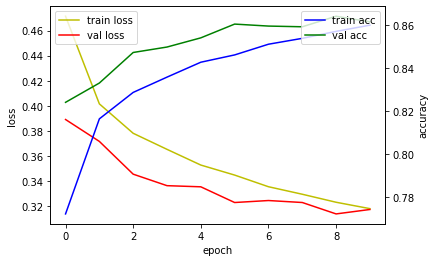

Epoch 1/10
938/938 [==============================] - 18s 15ms/step - loss: 0.5377 - accuracy: 0.7280 - val_loss: 0.4350 - val_accuracy: 0.7989
Epoch 2/10
938/938 [==============================] - 13s 14ms/step - loss: 0.4439 - accuracy: 0.7912 - val_loss: 0.3833 - val_accuracy: 0.8276
Epoch 3/10
938/938 [==============================] - 13s 14ms/step - loss: 0.4085 - accuracy: 0.8115 - val_loss: 0.3683 - val_accuracy: 0.8348
Epoch 4/10
938/938 [==============================] - 13s 14ms/step - loss: 0.3962 - accuracy: 0.8197 - val_loss: 0.3591 - val_accuracy: 0.8413
Epoch 5/10
938/938 [==============================] - 13s 14ms/step - loss: 0.3824 - accuracy: 0.8257 - val_loss: 0.3465 - val_accuracy: 0.8483
Epoch 6/10
938/938 [==============================] - 13s 14ms/step - loss: 0.3735 - accuracy: 0.8304 - val_loss: 0.3422 - val_accuracy: 0.8492
Epoch 7/10
938/938 [==============================] - 13s 14ms/step - loss: 0.3621 - accuracy: 0.8372 - val_loss: 0.3398 - val_accuracy:

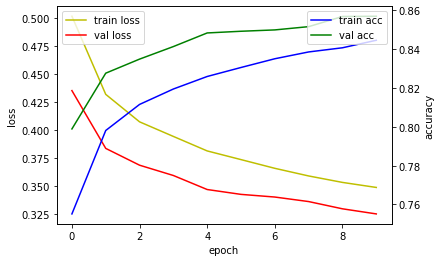

In [239]:
hyper_params = {
    'apply_attention': [True, False],
    'train_embedding_layer': [True, False],
    'dropout': [0.3],
    'weights': [w2v_output['weight'], w2v_output['norm_weight']]
}

histories = dict()
test_scores = dict()

for a in hyper_params['apply_attention']:
    for ef in hyper_params['is_embedding_layer_freezing']:
        for do in hyper_params['dropout']:
            for i, w in enumerate(hyper_params['weights']):
                model_name, history, test_score = \
                    train_and_evaluate(vocab_size, embedding_dim, 128, 10, 128, w, a, ef, do)
                model_name = f'{model_name}-{i}'
                histories[model_name] = history
                test_scores[model_name] = test_score

True-True-0.3-0
[0.4882357120513916, 0.8518959283828735]
0.8657955527305603


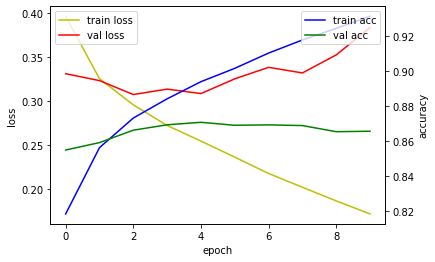

True-True-0.3-1
[0.4882357120513916, 0.8518959283828735]
0.8536950945854187


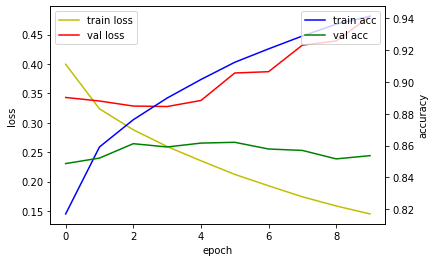

True-False-0.3-0
[0.4882357120513916, 0.8518959283828735]
0.8691623210906982


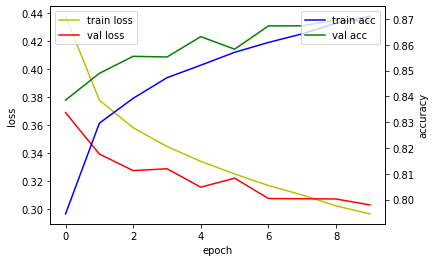

True-False-0.3-1
[0.4882357120513916, 0.8518959283828735]
0.8630287647247314


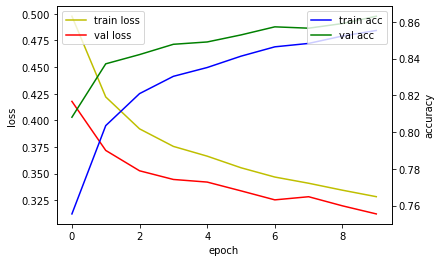

False-True-0.3-0
[0.4882357120513916, 0.8518959283828735]
0.8653339743614197


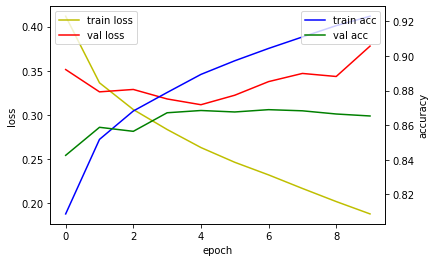

False-True-0.3-1
[0.4882357120513916, 0.8518959283828735]
0.8533199429512024


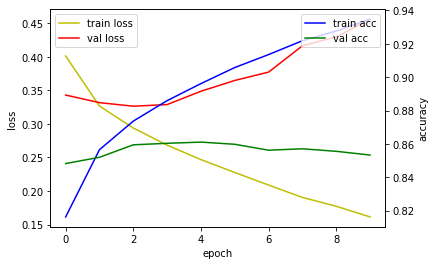

False-False-0.3-0
[0.4882357120513916, 0.8518959283828735]
0.8616803288459778


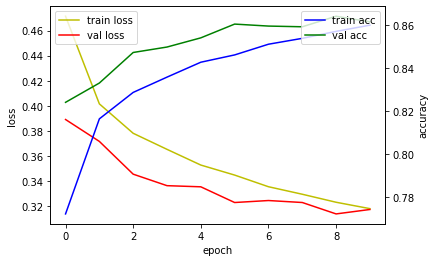

False-False-0.3-1
[0.4882357120513916, 0.8518959283828735]
0.8568920493125916


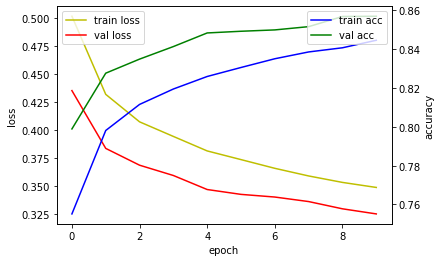

In [248]:
for h in histories:
    print(h)
    print(test_scores[h])
    print(histories[h].history['val_accuracy'][-1])
    plot_hist(histories[h])